Using device: cuda


C:\Users\park9\AppData\Local\Temp\ipykernel_31852\99132990.py:238: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)


Total combined size: 30353 samples

New random split (80/20):
  New Train set: 24282 samples
  New Test set:  6071 samples

Normalization stats (mean, std) computed from new train split.
  - Parameters: 77,083
Parameters      : 0.0771 M
FLOPs / sample : 9.071 M
Infer Time     : 3.09 ms/sample
[Physics*] Epoch 025/50 | Train Acc=99.26% | CE=0.3204 | Phys=0.4534 (λ_total=0.050) | Total=0.3431 || Test F1=0.9865 | Test Acc=98.73% (Best F1=0.9886, Best Acc=98.91%)
[Physics*] Epoch 050/50 | Train Acc=99.72% | CE=0.3061 | Phys=0.3823 (λ_total=0.050) | Total=0.3253 || Test F1=0.9927 | Test Acc=99.29% (Best F1=0.9927, Best Acc=99.29%)

Classification Report
                   precision    recall  f1-score   support

            Lying     1.0000    0.9949    0.9975       594
          Sitting     0.9929    0.9965    0.9947       565
         Standing     0.9701    0.9968    0.9833       619
          Walking     0.9973    1.0000    0.9986       734
          Running     1.0000    0.9968    0.998

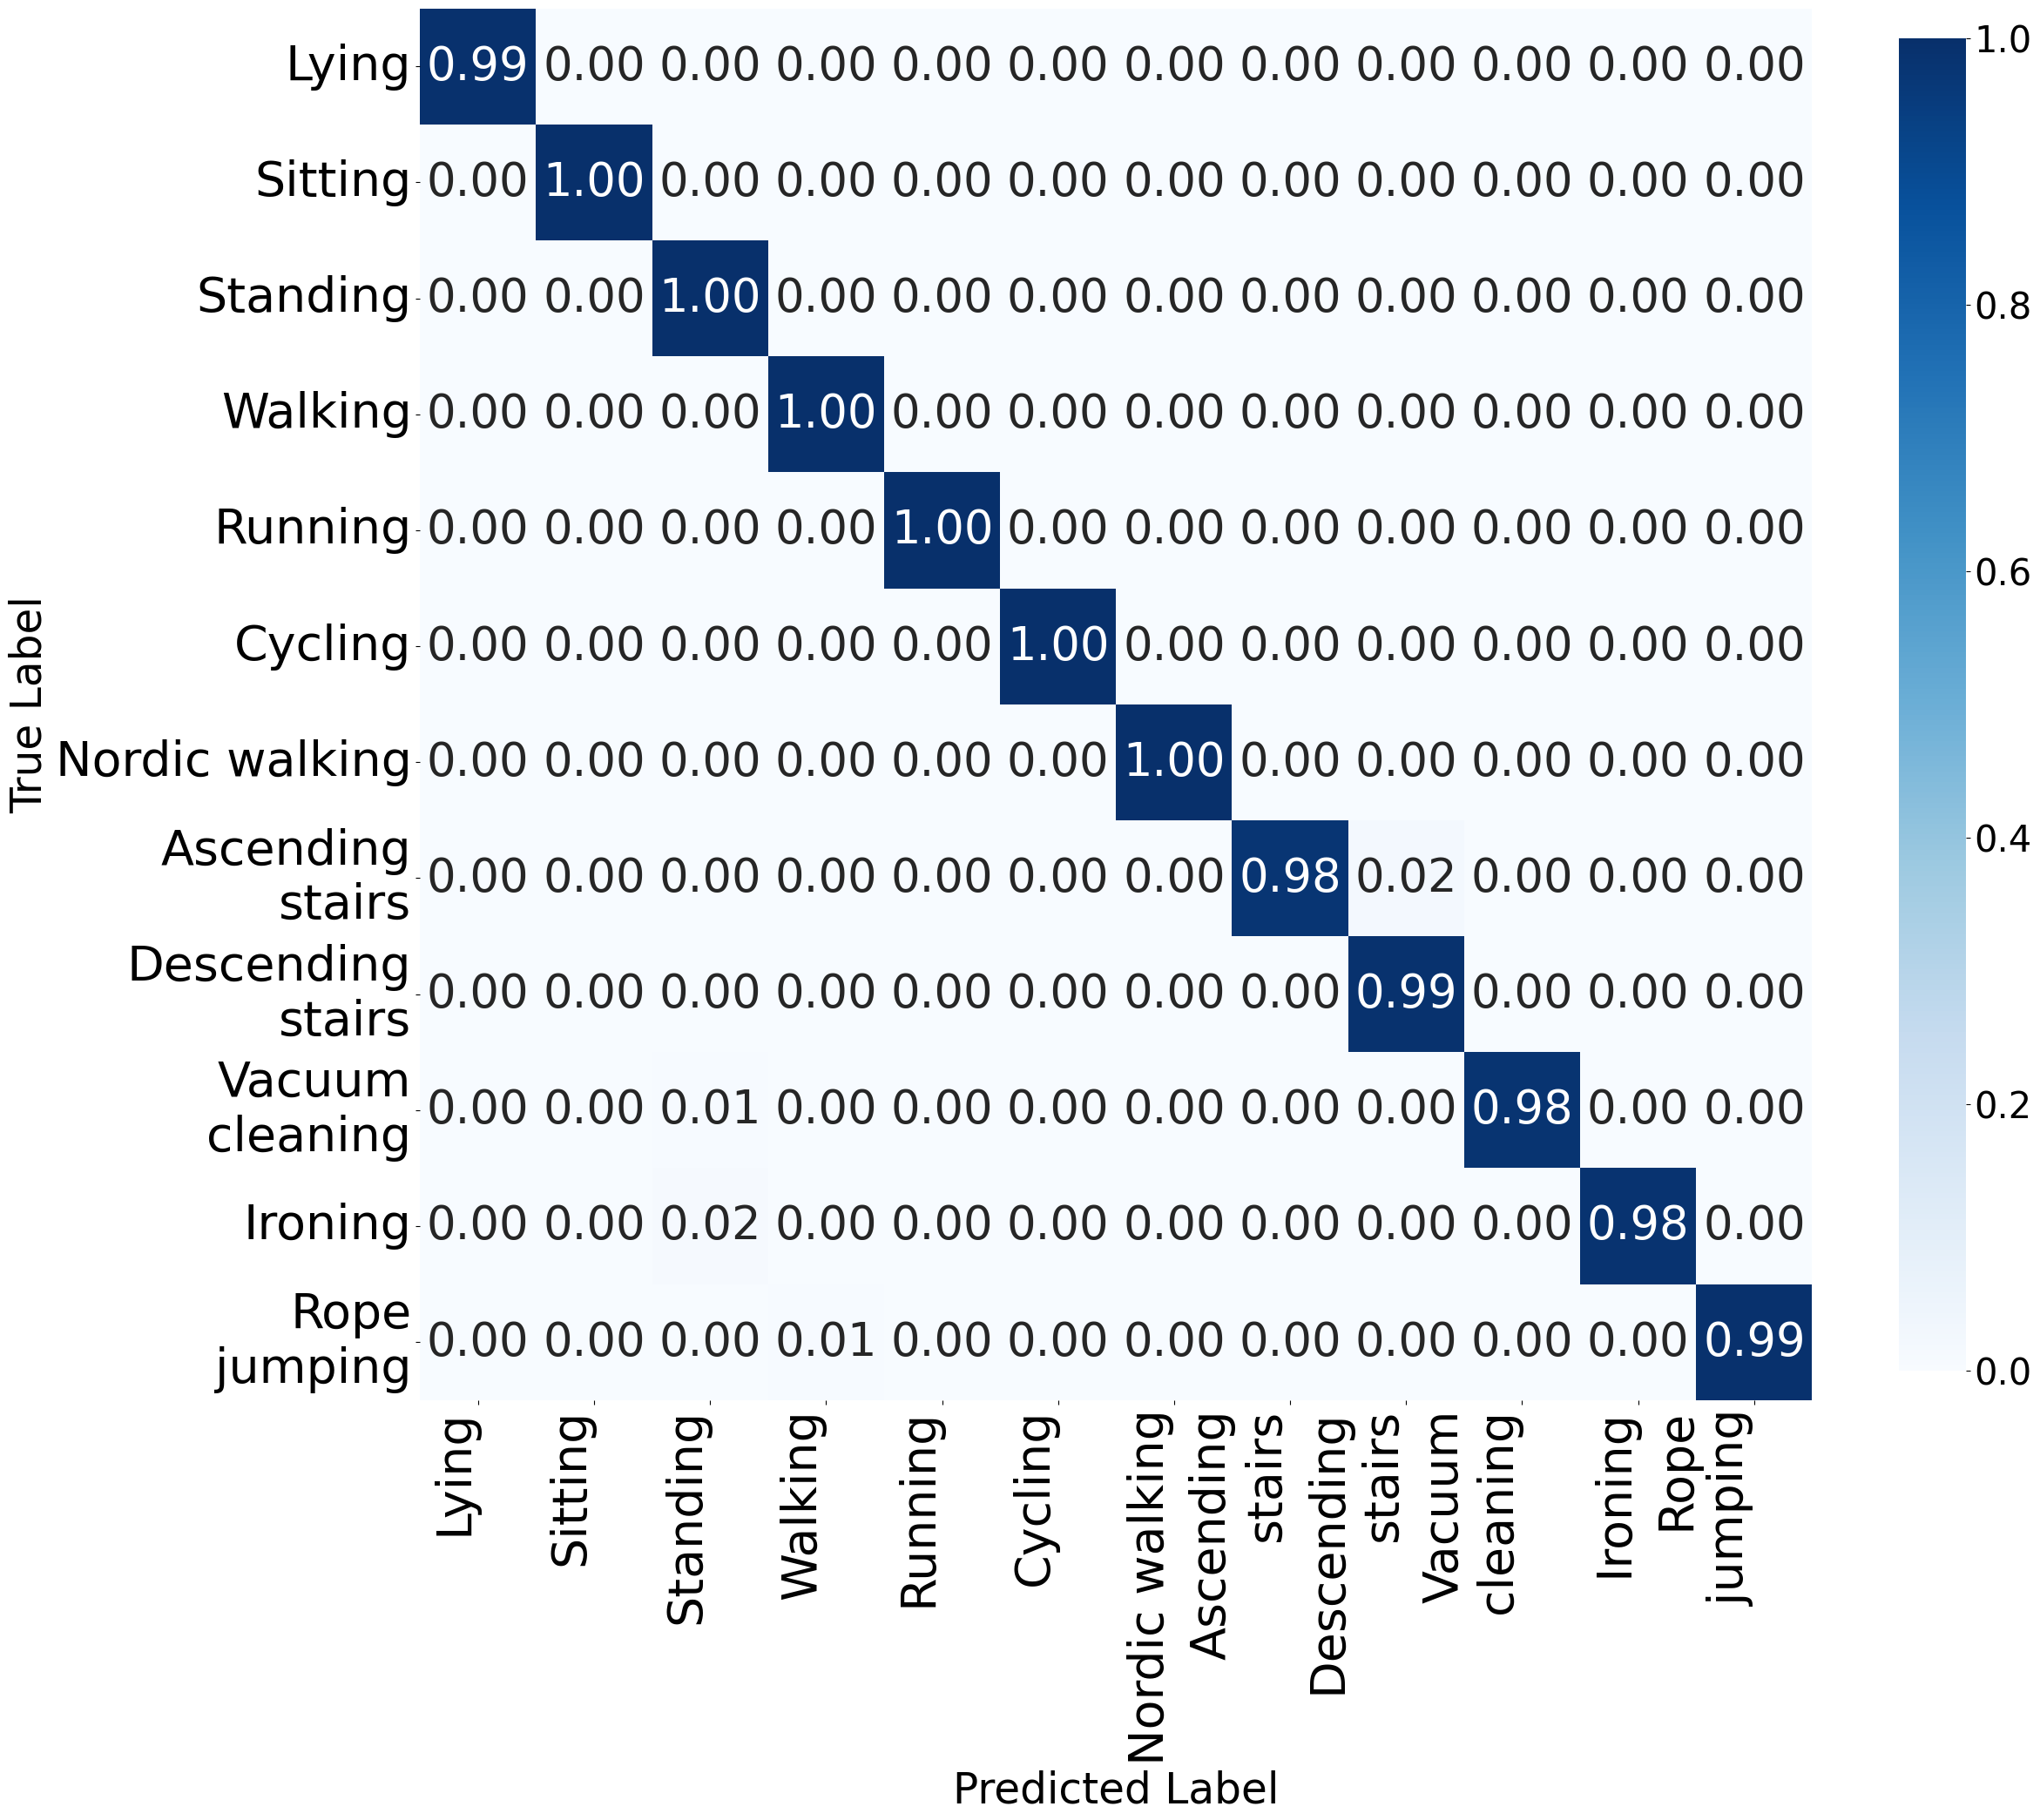

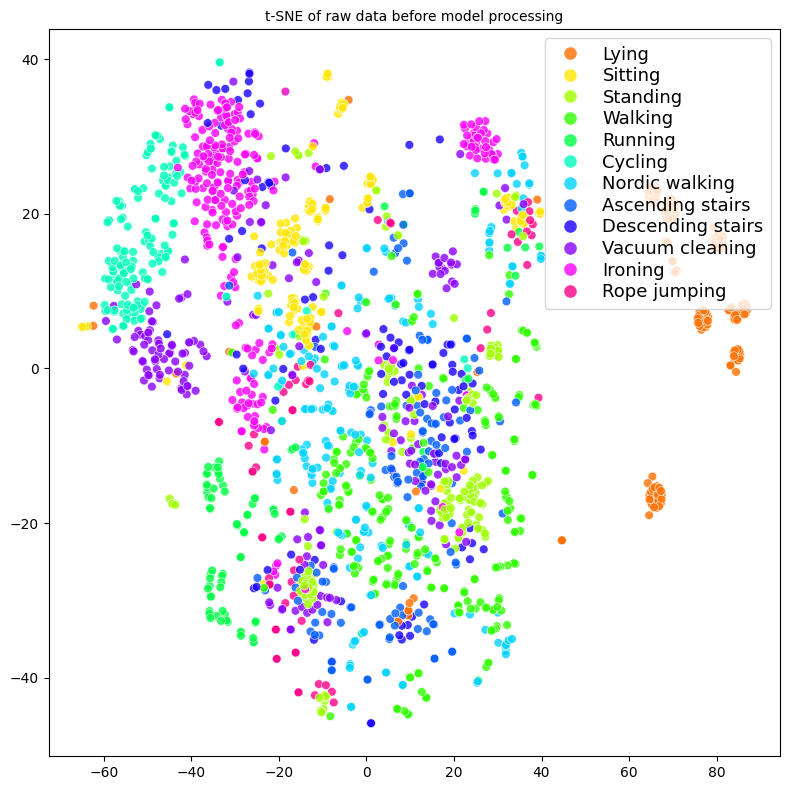


Running t-SNE on 2000 points (Perplexity=30)...


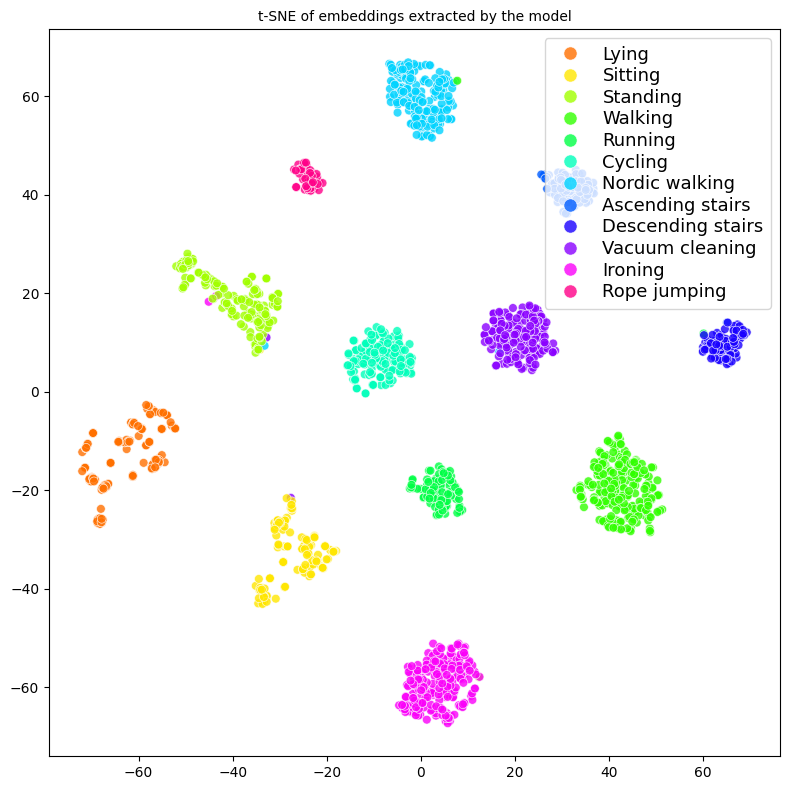

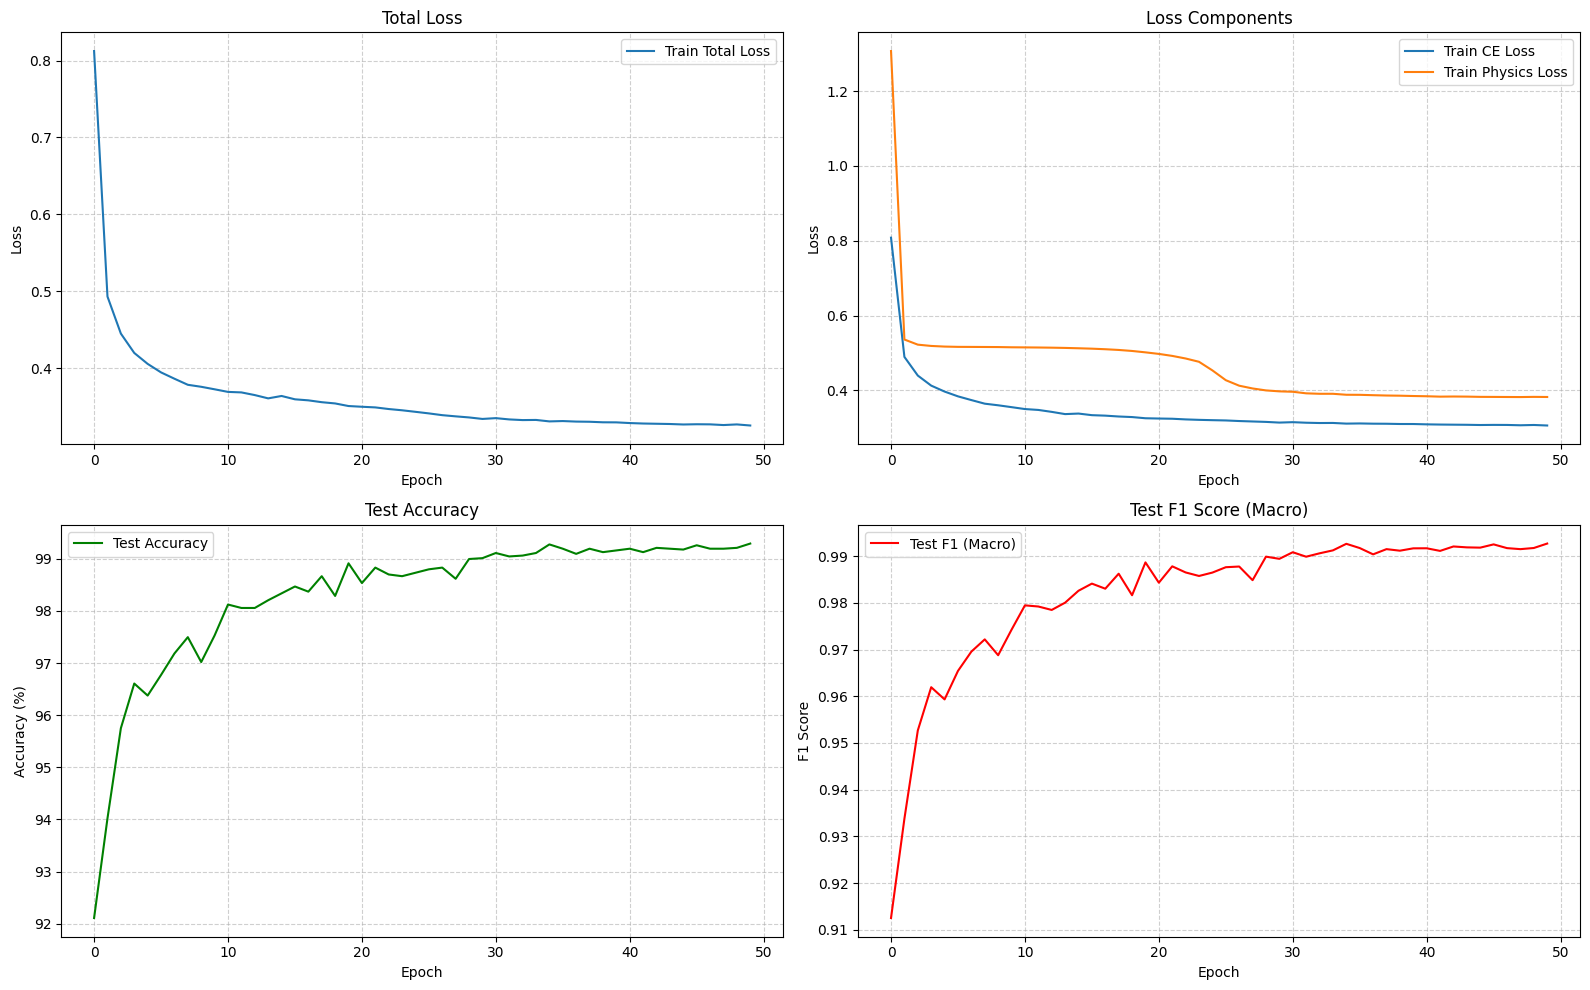

In [1]:
import os
import io
import re
import time
import glob
import random
import contextlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt    

from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix, classification_report 
from sklearn.preprocessing import StandardScaler   

try:
    from fvcore.nn import FlopCountAnalysis
    FVCORE_AVAILABLE = True
except ImportError:
    FlopCountAnalysis = None
    FVCORE_AVAILABLE = False

# ========================
# SEED 고정 함수
# ========================
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA 11+

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=False)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

# ========================
# PAMAP2 데이터 로드 
# ========================
def create_pamap2_windows(df: pd.DataFrame, window_size: int, step_size: int):
    """
    subject별로 timestamp 순서대로 전체 시계열을 따라가며 슬라이딩 윈도우 생성.
    한 윈도우의 라벨은 마지막 프레임의 activityID.
    마지막 라벨이 0(Null/기타) 이면 그 윈도우는 버린다.

    Returns:
        X:          (N, C, T) float32
        y:          (N,) int64  (0..11로 리맵된 레이블)
        subj_ids:   (N,) int64
        label_names:list[str] 길이 12, new_index -> human-readable
    """

    # 사용할 피처들 (orientation*, heartrate, *_Temperature 등은 제외)
    feature_cols = [
        # hand
        "handAcc16_1","handAcc16_2","handAcc16_3",
        "handAcc6_1","handAcc6_2","handAcc6_3",
        "handGyro1","handGyro2","handGyro3",
        "handMagne1","handMagne2","handMagne3",
        # chest
        "chestAcc16_1","chestAcc16_2","chestAcc16_3",
        "chestAcc6_1","chestAcc6_2","chestAcc6_3",
        "chestGyro1","chestGyro2","chestGyro3",
        "chestMagne1","chestMagne2","chestMagne3",
        # ankle
        "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
        "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
        "ankleGyro1","ankleGyro2","ankleGyro3",
        "ankleMagne1","ankleMagne2","ankleMagne3",
    ]

    # PAMAP2 실제 activityID들 중 우리가 쓰는 12개 클래스만 남김
    # 순서 고정: 이 순서가 new class index 0..11이 된다.
    ORDERED_IDS = [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]

    # 원본 activityID -> new index(0..11)
    old2new = {
        1: 0,   # Lying
        2: 1,   # Sitting
        3: 2,   # Standing
        4: 3,   # Walking
        5: 4,   # Running
        6: 5,   # Cycling
        7: 6,   # Nordic walking
        12: 7,  # Ascending stairs
        13: 8,  # Descending stairs
        16: 9,  # Vacuum cleaning
        17: 10, # Ironing
        24: 11, # Rope jumping
    }

    # new index -> 사람이 읽는 이름
    label_names = [
        "Lying",              # 0 -> orig 1
        "Sitting",            # 1 -> orig 2
        "Standing",           # 2 -> orig 3
        "Walking",            # 3 -> orig 4
        "Running",            # 4 -> orig 5
        "Cycling",            # 5 -> orig 6
        "Nordic walking",     # 6 -> orig 7
        "Ascending stairs",   # 7 -> orig 12
        "Descending stairs",  # 8 -> orig 13
        "Vacuum cleaning",    # 9 -> orig 16
        "Ironing",            # 10 -> orig 17
        "Rope jumping",       # 11 -> orig 24
    ]

    X_list = []
    y_list = []
    subj_list = []

    # subject별로 끊어서 시간 순 정렬 후 슬라이딩 윈도우
    for subj_id, g in df.groupby("subject_id"):
        # 시간순 정렬
        if "timestamp" in g.columns:
            g = g.sort_values("timestamp")
        else:
            g = g.sort_index()

        data_arr  = g[feature_cols].to_numpy(dtype=np.float32)   # (L, C)
        label_arr = g["activityID"].to_numpy(dtype=np.int64)     # (L,)
        L = data_arr.shape[0]

        start = 0
        while start + window_size <= L:
            end = start + window_size

            last_label_orig = int(label_arr[end - 1])

            # 0 = "other / null" → 버림
            if last_label_orig == 0:
                start += step_size
                continue

            # 우리가 쓰는 12개 클래스에 없는 라벨이면 버림
            if last_label_orig not in old2new:
                start += step_size
                continue

            # 윈도우 추출
            window_ct = data_arr[start:end].T  # (T, C) -> (C, T)

            X_list.append(window_ct)
            y_list.append(old2new[last_label_orig])
            subj_list.append(int(subj_id))

            start += step_size

    # numpy 변환
    X = np.stack(X_list, axis=0).astype(np.float32)      # (N, C, T)
    y = np.asarray(y_list, dtype=np.int64)               # (N,)
    subj_ids = np.asarray(subj_list, dtype=np.int64)     # (N,)

    return X, y, subj_ids, label_names

class PAMAP2Dataset(Dataset):
    def __init__(self, data_dir, window_size, step_size):
        super().__init__()

        # 1) CSV 전부 읽어서 하나의 df로 합치기
        csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
        if len(csv_files) == 0:
            raise RuntimeError(f"No CSV files found under {data_dir}")

        dfs = []
        for fpath in sorted(csv_files):
            df_i = pd.read_csv(fpath)

            if "subject_id" not in df_i.columns:
                m = re.findall(r"\d+", os.path.basename(fpath))
                subj_guess = int(m[0]) if len(m) > 0 else 0
                df_i["subject_id"] = subj_guess

            dfs.append(df_i)

        df = pd.concat(dfs, ignore_index=True)

        df = df.dropna(subset=['activityID'])
        
        # 기본 타입 정리
        df["activityID"] = df["activityID"].astype(np.int64)
        df["subject_id"] = df["subject_id"].astype(np.int64)
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

        # ===========================
        # (1) NaN 처리
        # ===========================
        feature_cols = [
            # hand
            "handAcc16_1","handAcc16_2","handAcc16_3",
            "handAcc6_1","handAcc6_2","handAcc6_3",
            "handGyro1","handGyro2","handGyro3",
            "handMagne1","handMagne2","handMagne3",
            # chest
            "chestAcc16_1","chestAcc16_2","chestAcc16_3",
            "chestAcc6_1","chestAcc6_2","chestAcc6_3",
            "chestGyro1","chestGyro2","chestGyro3",
            "chestMagne1","chestMagne2","chestMagne3",
            # ankle
            "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
            "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
            "ankleGyro1","ankleGyro2","ankleGyro3",
            "ankleMagne1","ankleMagne2","ankleMagne3",
        ]

        # subject별로 결측치 보간 -> ffill/bfill로 마저 메우기
        def _fill_subject_group(g):
            # 시간 순으로 정렬 (timestamp 있으면 timestamp 기준)
            if "timestamp" in g.columns:
                g = g.sort_values("timestamp")
            else:
                g = g.sort_index()

            # 각 컬럼별로 interpolate + ffill/bfill
            g[feature_cols] = (
                g[feature_cols]
                .interpolate(method="linear", limit_direction="both", axis=0)
                .ffill()
                .bfill()
            )
            return g

        df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)

        # 이 시점에서 feature_cols 안에 NaN이 남아있으면 안 됨
        # 혹시라도 남았으면 0으로 막아버리기 (safety net)
        df[feature_cols] = df[feature_cols].fillna(0.0)

        # ===========================
        # (2) 스케일 표준화 
        # ===========================
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])

        # ===========================
        # (3) 윈도우 생성
        # ===========================
        X, y, subj_ids, label_names = create_pamap2_windows(
            df,
            window_size=window_size,
            step_size=step_size,
        )

        self.X = X          # (N, C, T) float32
        self.y = y          # (N,)
        self.subject_ids = subj_ids
        self.label_names = label_names

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx], dtype=torch.long),
            self.subject_ids[idx]
        )

# ========================
# Modern TCN Components 
# ========================
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            padding=padding, dilation=dilation, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleConvBlock(nn.Module):
    def __init__(self, channels, kernel_sizes=[3, 5, 7], dilation=1, dropout=0.1):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = ((k - 1) * dilation) // 2
            branch = nn.ModuleDict({
                'conv': DepthwiseSeparableConv1d(channels, channels, k, dilation, padding),
                'norm': nn.BatchNorm1d(channels),
                'dropout': nn.Dropout(dropout)
            })
            self.branches.append(branch)
        self.fusion = nn.Conv1d(channels * len(kernel_sizes), channels, 1)

    def forward(self, x):
        outputs = []
        target_length = x.size(2)
        for branch in self.branches:
            out = branch['conv'](x)
            if out.size(2) != target_length:
                out = out[:, :, :target_length]
            out = branch['norm'](out)
            out = F.gelu(out)
            out = branch['dropout'](out)
            outputs.append(out)
        multi_scale = torch.cat(outputs, dim=1)
        return self.fusion(multi_scale)

class ModernTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 7], dilation=1, dropout=0.1):
        super().__init__()
        
        # NOTE: kernel_sizes가 [7]처럼 단일 리스트로 들어오면 Single-scale이 됨
        self.multi_conv1 = MultiScaleConvBlock(
            in_channels if in_channels == out_channels else out_channels,
            kernel_sizes, dilation, dropout
        )
        
        # NOTE: kernel_sizes 중 가장 큰 값을 기준으로 padding
        max_k = max(kernel_sizes) if isinstance(kernel_sizes, list) else kernel_sizes
        padding = ((max_k - 1) * dilation) // 2
        
        self.conv2 = DepthwiseSeparableConv1d(
            out_channels, out_channels, max_k, dilation, padding
        )
        self.norm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        target_length = x.size(2)
        if self.downsample is not None:
            x = self.downsample(x)
            residual = x
        
        out = self.multi_conv1(x)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        
        out = self.conv2(out)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        out = self.norm2(out)
        out = F.gelu(out)
        out = self.dropout2(out)
        return F.gelu(out + residual)

class SqueezeExcitation1d(nn.Module):
    def __init__(self, channels, reduction=5):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    def forward(self, x):
        batch, channels, _ = x.size()
        squeeze = F.adaptive_avg_pool1d(x, 1).view(batch, channels)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation)).view(batch, channels, 1)
        return x * excitation

class LargeKernelConv1d(nn.Module):
    def __init__(self, channels, kernel_size=21):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv1d(
            channels, channels, kernel_size,
            padding=padding, groups=channels
        )
        self.norm = nn.BatchNorm1d(channels)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.norm(out)
        return out

# ========================
# Modern TCN Base 모델 
# ========================
class BaseModernTCNHAR(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
                 kernel_sizes=[3, 7], large_kernel=21, dropout=0.1, use_se=True):
        super().__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, 1)
        self.large_kernel_conv = LargeKernelConv1d(hidden_dim, large_kernel)
        self.tcn_blocks = nn.ModuleList()
        for i in range(n_layers):
            dilation = 2 ** i
            self.tcn_blocks.append(
                ModernTCNBlock(
                    hidden_dim, hidden_dim,
                    kernel_sizes=kernel_sizes,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.final_large_kernel = LargeKernelConv1d(hidden_dim, large_kernel)
        # self.final_large_kernel = nn.Identity()
        self.use_se = use_se
        if use_se:
            self.se = SqueezeExcitation1d(hidden_dim)
        self.norm_final = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.large_kernel_conv(x)
        x = F.gelu(x)
        for block in self.tcn_blocks:
            x = block(x)
        x = self.final_large_kernel(x)
        x = F.gelu(x)
        if self.use_se:
            x = self.se(x)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x = self.norm_final(x)
        return self.head(x)

# ========================
# Physics-Guided Modern TCN HAR 
# ========================
class PhysicsModernTCNHAR(BaseModernTCNHAR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        hidden_dim = self.head.in_features

        self.gravity_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3)
        )

    def forward(self, x, return_gravity=False):
        x_feat = self.input_proj(x)
        x_feat = F.gelu(self.large_kernel_conv(x_feat))
        for block in self.tcn_blocks:
            x_feat = block(x_feat)
        x_feat = F.gelu(self.final_large_kernel(x_feat))
        if self.use_se:
            x_feat = self.se(x_feat)

        pooled = F.adaptive_avg_pool1d(x_feat, 1).squeeze(-1)
        pooled = self.norm_final(pooled)
        logits = self.head(pooled)

        outs = [logits]

        if return_gravity:
            seq_feat = x_feat.transpose(1, 2)  # (B,T,C)
            gvec = self.gravity_head(seq_feat)   # (B,T,3)
            outs.append(gvec)

        return tuple(outs) if len(outs) > 1 else outs[0]

# ========================
# '물리 손실' 함수 
# ========================
def fir_lpf_hann_bt3(x, K=31):
    """
    x: (B,T,3)  -> a_lp, a_hp (둘 다 (B,T,3))
    간단 Hann 창 평균 기반 LPF. HPF = x - LPF
    """
    assert x.dim() == 3 and x.size(-1) == 3
    B, T, C = x.shape
    xc = x.transpose(1, 2)  # (B,3,T)
    w = torch.hann_window(K, dtype=xc.dtype, device=xc.device)
    w = (w / w.sum()).view(1,1,-1).expand(C,1,-1)  # (3,1,K)
    a_lp = F.conv1d(xc, w, padding=K//2, groups=C).transpose(1, 2)
    a_hp = x - a_lp
    return a_lp, a_hp

def unit_norm(v, eps=1e-8):
    return v / (v.norm(dim=-1, keepdim=True) + eps)

def diff1(x):
    # x: (B,T,D) -> same shape with zero-pad at t=0
    d = x[:, 1:] - x[:, :-1]
    pad = torch.zeros(x.size(0), 1, x.size(2), device=x.device, dtype=x.dtype)
    return torch.cat([pad, d], dim=1)


@torch.no_grad()
def estimate_dt_from_freq(default_dt=1/50):
    # UCI-HAR≈50Hz, MHEALTH≈50Hz, WISDM≈20Hz, PAMAP2≈100Hz
    return default_dt

def physics_loss_upgraded(
    X_raw,          # (B,T,9): [:,:,:3]=acc, [:,:,3:6]=gyro
    g_pred,         # (B,T,3): gravity unit vector (모델 예측)
    lambdas,        # dict: 각 항 가중치
    params          # dict: 하이퍼파라미터(tau_w,tau_a,alpha_lp,alpha_comp,win_mean,dt,g0)
):
    acc = X_raw[:, :, 12:15]
    gyro = X_raw[:, :, 18:21]
    eps = 1e-8

    # 1) LPF로 중력후보, HPF로 동적성분
    a_lp, a_hp = fir_lpf_hann_bt3(acc, K=params.get('K', 31))
    g_from_acc = unit_norm(a_lp, eps=eps)

    # 2) 게이팅: 정적/완만 구간만 신뢰
    tau_w = params.get('tau_w', 1.0)
    tau_a = params.get('tau_a', 0.5)
    gate = ((gyro.norm(dim=-1) < tau_w) & (a_hp.norm(dim=-1) < tau_a)).float()  # (B,T)

    # 3) g_pred 정규화
    g_pred = unit_norm(g_pred, eps=eps)

    # 4) 각 항 계산
    # (a) 방향 정렬 (LPF(acc)와 정렬)
    cos_sim = (g_from_acc * g_pred).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)
    L_grav = torch.acos(cos_sim).mean()

    # (b) 중력 크기 (정규화된 입력이면 g0≈1.0)
    g0 = params.get('g0', 1.0)
    L_gmag = (gate * (acc.norm(dim=-1) - g0).pow(2)).mean()

    # (c) 보완필터 잔차: g_comp vs g_pred
    alpha_c = params.get('alpha_comp', 0.97)
    dt = params.get('dt', estimate_dt_from_freq())
    g_prev = torch.roll(g_pred, shifts=1, dims=1)
    g_gyro = unit_norm(g_prev - dt * torch.cross(gyro, g_prev, dim=-1), eps=eps)
    g_acc  = unit_norm(acc, eps=eps)
    g_comp = unit_norm(alpha_c * g_gyro + (1 - alpha_c) * g_acc, eps=eps)
    L_comp = torch.acos((g_comp * g_pred).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)).mean()

    # (d) 자이로 바이어스(창 평균≈0) & (e) 스무딩(jerk/ω̇)
    win = params.get('win_mean', 16)
    gyro_m = fir_lpf_hann_bt3(gyro, K=max(3, 2* (win//2)+1))[0]  # 창 평균 대용
    L_bias = (gate * gyro_m.pow(2).sum(dim=-1)).mean()
    da = diff1(acc);  dw = diff1(gyro)
    L_smooth = (da.pow(2).sum(dim=-1) + dw.pow(2).sum(dim=-1)).mean()

    # (f) 분해 일관성: a_total = a_body + g0*ĝ → a_body 창 평균이 0 근처
    a_body = acc - g0 * g_pred
    a_body_m = fir_lpf_hann_bt3(a_body, K=max(3, 2* (win//2)+1))[0]  # 로우패스=윈도 평균
    L_split = a_body_m.norm(dim=-1).mean()

    # (g) 미분운동학: dg/dt ≈ -ω×g
    dg = diff1(g_pred) / max(dt, 1e-3)
    w_cross_g = torch.cross(gyro, g_pred, dim=-1)
    L_pinn = (dg + w_cross_g).pow(2).sum(dim=-1).mean()

    L = (
        lambdas.get('grav', 0.10)   * L_grav  +
        lambdas.get('gmag', 0.05)   * L_gmag  +
        lambdas.get('comp', 0.10)   * L_comp  +
        lambdas.get('bias', 0.02)   * L_bias  +
        lambdas.get('smooth', 0.02) * L_smooth+
        lambdas.get('split', 0.05)  * L_split +
        lambdas.get('pinn', 0.03)   * L_pinn
    )

    stats = dict(grav=L_grav.item(), gmag=L_gmag.item(), comp=L_comp.item(),
                 bias=L_bias.item(), smooth=L_smooth.item(),
                 split=L_split.item(), pinn=L_pinn.item())
    return L, stats


# ========================
# 헬퍼: 파라미터 카운트
# ========================
def get_n_params(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

# ========================
# '물리 기반' 학습 함수 (F1 Score 기준)
# ========================
def train_physics(model, train_loader, test_loader, device, n_classes, epochs=50, lambda_phys=0.05, log_every=1):
    """
    lambda_phys: 총 물리손실 스케일 (각 항 상대가중치는 내부 lambdas)
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # 상대 가중치 (스타팅 포인트)
    base_lambdas = dict(grav=0.15, comp=0.15, split=0.10, gmag=0.03, bias=0.01, smooth=0.01, pinn=0.05)
    # 하이퍼 (데이터 표준화/주파수에 맞게 조정)
    params = dict(
        tau_w=1.0, tau_a=0.5, alpha_comp=0.97,
        win_mean=16, dt=estimate_dt_from_freq(), g0=1.0, K=31
    )

    best_f1 = best_acc = 0.0
    history = {"train_ce": [], "train_phys": [], "train_total": [], "test_acc": [], "test_f1": []}

    warm_epochs = 15
    best_state = None
    best_eval_cache = None

    for epoch in range(1, epochs + 1):
        model.train()
        ce_sum = phys_sum = total_sum = 0.0
        correct = total = 0

        # warm-up 스케일: 초반엔 λ_phys를 선형 증가
        if epoch <= warm_epochs:
            phys_scale = lambda_phys * (epoch / warm_epochs)
        else:
            phys_scale = lambda_phys

        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits, gvec = model(X, return_gravity=True)
            loss_ce = F.cross_entropy(logits, y, label_smoothing=0.05)
            L_phys, stats = physics_loss_upgraded(X.transpose(1, 2), g_pred=gvec, lambdas=base_lambdas, params=params)

            loss = loss_ce + phys_scale * L_phys
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            ce_sum += loss_ce.item(); phys_sum += L_phys.item(); total_sum += loss.item()
            preds = logits.argmax(1); correct += (preds == y).sum().item(); total += y.size(0)

        scheduler.step()

        n_batches = len(train_loader)
        ce_avg, phys_avg, total_avg = ce_sum/n_batches, phys_sum/n_batches, total_sum/n_batches
        train_acc = 100.0 * correct / total

        # ===== 평가 =====
        model.eval()
        test_correct = test_total = 0
        all_preds, all_y = [], []
        all_feats = []

        with torch.inference_mode():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)

                feats = model.input_proj(X)
                feats = model.large_kernel_conv(feats)
                feats = F.gelu(feats)
                for block in model.tcn_blocks:
                    feats = block(feats)
                feats = model.final_large_kernel(feats)
                feats = F.gelu(feats)
                if model.use_se:
                    feats = model.se(feats)
                pooled = F.adaptive_avg_pool1d(feats, 1).squeeze(-1)
                pooled = model.norm_final(pooled)

                logits = model.head(pooled)
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item()
                test_total   += y.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())
                all_feats.append(pooled.cpu().numpy())

        test_acc = 100.0 * test_correct / test_total
        test_f1 = f1_score(all_y, all_preds, labels=list(range(n_classes)), average='macro', zero_division=0)
        best_acc = max(best_acc, test_acc)

        if test_f1 > best_f1 + 1e-9:
            best_f1 = test_f1
            best_acc = max(best_acc, test_acc)
            # CPU 텐서로 깊은 복사
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            # 베스트 시점 캐시 저장
            best_eval_cache = {
                "y":     np.array(all_y, dtype=np.int64),
                "preds": np.array(all_preds, dtype=np.int64),
                "feats": np.concatenate(all_feats, axis=0)  # (N, D)
            }

        history["train_ce"].append(ce_avg); history["train_phys"].append(phys_avg)
        history["train_total"].append(total_avg); history["test_acc"].append(test_acc); history["test_f1"].append(test_f1)

        if (epoch % log_every) == 0:
            print(f"[Physics*] Epoch {epoch:03d}/{epochs} | Train Acc={train_acc:.2f}% | "
                  f"CE={ce_avg:.4f} | Phys={phys_avg:.4f} (λ_total={phys_scale:.3f}) | "
                  f"Total={total_avg:.4f} || Test F1={test_f1:.4f} | Test Acc={test_acc:.2f}% "
                  f"(Best F1={best_f1:.4f}, Best Acc={best_acc:.2f}%)")

    return best_f1, best_acc, history, best_state, best_eval_cache  


# ========================
# 시각화 함수
# ========================
ACTIVITY_LABELS = [
    "Lying",             
    "Sitting",            
    "Standing",         
    "Walking",           
    "Running",           
    "Cycling",          
    "Nordic walking",     
    "Ascending stairs",   
    "Descending stairs",
    "Vacuum cleaning", 
    "Ironing",        
    "Rope jumping",  
]

# Confusion Matrix용 (줄바꿈)
ACTIVITY_LABELS_CM = [
    "Lying",             
    "Sitting",            
    "Standing",         
    "Walking",           
    "Running",           
    "Cycling",          
    "Nordic walking",     
    "Ascending\nstairs",   
    "Descending\nstairs",
    "Vacuum\ncleaning", 
    "Ironing",        
    "Rope\njumping",  
]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))

def plot_classification_results(y_true, y_pred, save_path=None):
    """
    Confusion Matrix 시각화 
    """
    # 1. Classification Report 출력
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS,
            digits=4,
            zero_division=0,
        )
    )

    # 2. 정규화된 Confusion Matrix 계산 및 시각화
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(25, 25))
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 38}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS_CM, yticklabels=ACTIVITY_LABELS_CM)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)

    plt.xlabel('Predicted Label', fontsize=35)
    plt.ylabel('True Label', fontsize=35)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=40)
    plt.yticks(rotation=0, fontsize=40)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path
        plt.savefig(pdf_save_path, dpi=600)

    plt.show()
    plt.close()


def _extract_featvec_before_classifier(model, xb, device):
    """
    model.forward()의 흐름을 그대로 따라가되
    classifier 직전의 feature vector(feat_vec, shape (B, embed_dim))만 추출.
    이건 visualize_tsne에서 feature space로 쓸 거임.

    xb: (B, C_in, T) on CPU
    returns: (B, embed_dim) on CPU (no grad)
    """
    xb = xb.to(device)

    # 1. Embedding (+CBAM)
    x = model.embedding(xb)                  # (B, embed_dim, T)
    if model.use_cbam:
        x = model.cbam(x)                    # (B, embed_dim, T)

    # 2. 준비: (B, C, T) -> (B, T, C)
    x = x.transpose(1, 2).contiguous()       # (B, T, embed_dim)

    # 3. Dim reduction (optional)
    if model.use_dim_reduction:
        x = model.dim_reduce(x)              # (B, T, reduced_dim)

    # 4. Attention backbone
    if model.use_crossformer:
        # contrast 안 쓸 거라 proto_features 필요 없음
        # eval 시에는 실제 inference 경로로 skip_cross_attention=False 가 더 정직
        x = model.crossformer(
            x,
            return_proto_features=False,
            skip_cross_attention=False
        )                                    # (B, T, working_dim)
    else:
        # fallback self-attention
        x = model.self_attn(x)               # (B, T, working_dim)

    # 5. Dim restore (optional)
    if model.use_dim_reduction:
        x = model.dim_restore(x)             # (B, T, embed_dim)

    # 6. Pooling과 동일하게 처리
    # (B, T, embed_dim) -> (B, embed_dim, T)
    x = x.transpose(1, 2).contiguous()       # (B, embed_dim, T)
    feat_vec = model.pool(x).squeeze(-1)     # (B, embed_dim)

    return feat_vec.detach().cpu()           # CPU로 반환, grad 없이

def plot_tsne_from_cached_features(feats, labels, save_path=None, max_points=2000):
    """
    train_physics에서 저장한 best_eval["feats"]와 best_eval["y"]를
    받아서 t-SNE로 시각화합니다.
    """
    all_features = feats  # (N, D)
    all_labels = labels    # (N,)

    # 샘플 수 줄이기
    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]  # (M, D)
    y_sel = all_labels[idx]    # (M,)

    # perplexity는 (샘플 수 - 1)보다 작아야 함
    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning t-SNE on {len(X_sel)} points (Perplexity={effective_perp})...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_sel)  # (M, 2)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=150)

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, save_path=None, max_points=2000):
    """
    모델을 거치기 전의 raw window (shape: B x C x T)를 flatten해서 t-SNE로 투영.

    - dataloader: 보통 val_loader나 test_loader 넣는 걸 추천 (train 넣으면 class 간경계 너무 깨끗하게 나오는 경우 많음)
    - max_points: t-SNE에 사용할 최대 샘플 수
    """
    all_raw = []
    all_labels = []

    for xb, yb, _ in dataloader:
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)       # (N, C, T)
    all_labels = np.concatenate(all_labels, axis=0) # (N,)

    # 샘플 수 줄이기
    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]    # (M, C, T)
    y_sel = all_labels[idx] # (M,)

    # flatten: (M, C*T)
    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40, 
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path
        plt.savefig(pdf_save_path, bbox_inches="tight")

    plt.show()
    plt.close()


def plot_history(history, save_path=None):
    """
    train_physics에서 반환된 history 딕셔너리를 시각화합니다.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Total Loss
    axes[0, 0].plot(history['train_total'], label='Train Total Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Loss Components
    axes[0, 1].plot(history['train_ce'], label='Train CE Loss')
    axes[0, 1].plot(history['train_phys'], label='Train Physics Loss')
    axes[0, 1].set_title('Loss Components')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Test Accuracy
    axes[1, 0].plot(history['test_acc'], label='Test Accuracy', color='green')
    axes[1, 0].set_title('Test Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Test F1 Score
    axes[1, 1].plot(history['test_f1'], label='Test F1 (Macro)', color='red')
    axes[1, 1].set_title('Test F1 Score (Macro)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
        
    plt.show()
    plt.close()

# =================================================================================
# Model profiling: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model,
                  sample_input: torch.Tensor,
                  device: torch.device,
                  warmup: int = 10,
                  iters: int = 50):
    """
    모델 구조/비용 측정:
      - 파라미터 수 (M 단위)
      - FLOPs per sample (M 단위, fvcore 있으면)
      - 평균 추론 시간 (ms / sample)

    fvcore가 stdout/stderr에 시끄럽게 프린트하는 걸 다 먹어버린다.
    """

    model = model.to(device)
    model.eval()

    # -------------------------------------------------
    # 1) 파라미터 수
    # -------------------------------------------------
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6  # million params

    # -------------------------------------------------
    # 2) FLOPs 측정 (fvcore 사용 가능할 때만)
    #    - 모든 stdout/stderr을 임시 버퍼로 리다이렉트해서
    #      "Unsupported operator ..." 같은 중얼거림을 완전히 감춘다.
    # -------------------------------------------------
    flops_m = None
    if "FVCORE_AVAILABLE" in globals() and FVCORE_AVAILABLE and FlopCountAnalysis is not None:
        try:
            with torch.no_grad():
                fake_out = io.StringIO()
                fake_err = io.StringIO()
                with contextlib.redirect_stdout(fake_out), contextlib.redirect_stderr(fake_err):
                    flops = FlopCountAnalysis(model, (sample_input.to(device),))
                    total_flops = flops.total()
            flops_m = total_flops / 1e6  # to millions
        except Exception:
            flops_m = None
    else:
        flops_m = None

    # -------------------------------------------------
    # 3) 추론 시간 측정
    # -------------------------------------------------
    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }



def print_model_profile(stats_dict):
    print("=" * 80)
    print(f"Parameters      : {stats_dict['params_m']:.4f} M")
    print(f"FLOPs / sample : {stats_dict['flops_m']:.3f} M")
    print(f"Infer Time     : {stats_dict['inference_ms']:.2f} ms/sample")
    print("=" * 80)

# ========================
# 메인 실행 함수 (Ablation Study)
# ========================
def main():
    set_seed(42) 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    data_path = 'C://Users/park9/ModernTCN_Physics/data' 
    window_size = 128 
    step_size = 64    
    N_CHANNELS = 36   
    N_CLASSES = 12    
    BATCH_SIZE = 64   
    EPOCHS = 50     
    
    # -----------------------------
    # Load DataSet
    # -----------------------------
    full_dataset = PAMAP2Dataset(
        data_dir=data_path,
        window_size=window_size,
        step_size=step_size,
    )

    # label_names (for CM / t-SNE legend later)
    label_names = full_dataset.label_names

    total_size = len(full_dataset)
    print(f"Total combined size: {total_size} samples")

    split_ratio = 0.8 # Train 80%
    train_size = int(total_size * split_ratio)
    test_size = total_size - train_size

    indices = list(range(total_size))
    np.random.seed(42)
    np.random.shuffle(indices)

    new_train_ds = Subset(full_dataset, indices[:train_size])
    new_test_ds = Subset(full_dataset, indices[train_size:]) 
    
    print(f"\nNew random split (80/20):")
    print(f"  New Train set: {len(new_train_ds)} samples")
    print(f"  New Test set:  {len(new_test_ds)} samples\n")

    def compute_train_stats(train_subset):
        X_train = torch.from_numpy(train_subset.dataset.X[train_subset.indices]).float()
        mean = X_train.mean(dim=(0,1), keepdim=True)
        std  = X_train.std(dim=(0,1), keepdim=True).clamp_min(1e-6)
        return mean, std

    mean, std = compute_train_stats(new_train_ds)
    print("Normalization stats (mean, std) computed from new train split.")

    def collate_norm(batch):
        X, y, s = zip(*batch)
        X = torch.stack(X, dim=0).float()
        X = (X - mean) / std
        y = torch.tensor(y, dtype=torch.long)
        s = torch.tensor(s, dtype=torch.long)
        return X, y, s

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(
        new_train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, drop_last=True,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    test_loader = DataLoader(
        new_test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, drop_last=False,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    
    results = {} # 결과 저장 딕셔너리

    # ---
    # Full Model
    # ---
    set_seed(42)
    model = PhysicsModernTCNHAR( 
        input_dim=N_CHANNELS, # 23
        hidden_dim=64, n_layers=3, 
        n_classes=N_CLASSES, # 12
        kernel_sizes=[3, 7], large_kernel=19, 
        dropout=0.4, use_se=True
    ).to(device)
    print(f"  - Parameters: {get_n_params(model)}")

    # ========================
    # 모델 프로파일링
    # ========================
    sample_input_shape = (1, N_CHANNELS, window_size) # (1, 128, 23)
    sample_input = torch.randn(sample_input_shape).to(device)
    profile_stats = profile_model(model, sample_input, device)
    print_model_profile(profile_stats)

    # ========================
    # 모델 학습
    # ========================
    f1_3, acc_3, hist, best_state, best_eval = train_physics(model, train_loader, test_loader, device,
                                            n_classes=N_CLASSES, epochs=EPOCHS, lambda_phys=0.05, log_every=25) 
    
    # ========================
    # 결과 시각화
    # ========================
    # 1. Classification Report & Confusion Matrix (PNG 저장)
    plot_classification_results(
        best_eval["y"], 
        best_eval["preds"], 
        save_path="cm_pamap2.png" 
    )

    # 2. t-SNE (Raw Data)
    visualize_tsne_raw(
        test_loader, 
        save_path="tsne_raw_pamap2.png" 
    )

    # 3. t-SNE (Model Features) (새 함수 호출)
    plot_tsne_from_cached_features(
        best_eval["feats"],
        best_eval["y"],
        save_path="tsne_model_pamap2.png" 
    )

    # 4. 학습 이력 (새 함수 호출)
    plot_history(
        hist, 
        save_path="history_pamap2.png" 
    )

if __name__ == '__main__':
    main()